In [1]:
import utils
from scipy.ndimage import filters, measurements
import matplotlib.pyplot as plt
import cv2
from skimage import measure,color
from skimage.morphology import remove_small_objects, watershed
import json
from openslide import OpenSlide
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
import scipy.io as sio
import numpy as np
import os
import glob

In [2]:
slide_path = '/home/bnc/tool/HistomicsML/yourproject/hover_net/slide/'
json_path = '/home/bnc/tool/HistomicsML/yourproject/hover_net/json/'
recentage_path = '/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/'
image_path = '/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/image/'
save_path = '/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/image/result/'
save_npy_path = '/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/npy/'

In [3]:
def get_cor(info):
    ans = []
    for reigon in info:
        points = reigon['points']
        X = []
        Y = []
        i = 0
        while(i<len(points)-1):
            X.append(points[i])
            Y.append(points[i+1])
            i = i + 2
        nuclei = {}
        nuclei['x_zuobiao'] = X
        nuclei['y_zuobiao'] = Y
        ans.append(nuclei)
    return ans

In [4]:
def get_size(ans):
    X = []
    Y = []
    for nuclei in ans:
        X = X + nuclei['x_zuobiao']
        Y = Y + nuclei['y_zuobiao']
    res_x_min = min(X)
    res_x_max = max(X)
    res_y_min = min(Y)
    res_y_max = max(Y)
    return res_x_min,res_x_max,res_y_min,res_y_max

In [5]:
def filter_nuclei(ans_recentage,ans_xibaohe):
    x_min,x_max,y_min,y_max = get_size(ans_recentage)
    res_reigon = []
    for region in ans_xibaohe:
        X = region['x_zuobiao']
        Y = region['y_zuobiao']
        X_temp = [x for x in X if x>=x_min and x<=x_max]
        Y_temp = [y for y in Y if y>=y_min and y<=y_max]
        if(len(X)==len(X_temp) and len(Y)==len(Y_temp)):
            res_reigon.append(reigon)
    return res_reigon

In [6]:
def tiaozheng(ans_recentage,ans_json):
    x_min,x_max,y_min,y_max = get_size(ans_recentage)
    for nuclei in ans_json:
        nuclei['x_zuobiao'] = [int(data - x_min) for data in nuclei['x_zuobiao']]
        nuclei['y_zuobiao'] = [int(data - y_min) for data in nuclei['y_zuobiao']]

In [17]:
def draw(image_path,json_path,rec_path,save_path):
    info_rec = utils.openjson(rec_path)
    info_json = utils.openjson(json_path)
    ans_rec = get_cor(info_rec)
    ans_json = get_cor(info_json)
    print("tiaozhengqian ==>{}".format(len(ans_json)))
    ans_json = filter_nuclei(ans_rec,ans_json)
    print("tiaozhenghou ==>{}".format(len(ans_json)))
    tiaozheng(ans_rec,ans_json)
    tile = cv2.imread(image_path)
    for nuclei in ans_json:
        x_cor = nuclei['x_zuobiao']
        y_cor = nuclei['y_zuobiao']
        res = []
        for i in range(0,len(x_cor)):
            temp = []
            temp.append(x_cor[i])
            temp.append(y_cor[i])
            res.append(temp)
        res = np.array(res,dtype = np.int32)
        cv2.polylines(tile,np.int32([res]),True,(0,255,0),thickness=3)
    cv2.imwrite(save_path+'{}_result.png'.format(os.path.basename(image_path).split('.')[0]),tile)
    
    

In [24]:
def generate_npy(json_path,rec_path,image_path,save_path):
    print(json_path)
    print(rec_path)
    info_rec = utils.openjson(rec_path)
    info_json = utils.openjson(json_path)
    ans_rec = get_cor(info_rec)
    ans_json = get_cor(info_json)
    print("tiaozhengqian ==>{}".format(len(ans_json)))
    ans_json = filter_nuclei(ans_rec,ans_json)
    print("tiaozhenghou ==>{}".format(len(ans_json)))
    tiaozheng(ans_rec,ans_json)
    image = cv2.imread(image_path)
    hw= image.shape[:2]
    insts_list = []
    for idx,nuclei in enumerate(ans_json):
        x_cor = nuclei['x_zuobiao']
        y_cor = nuclei['y_zuobiao']
        res = []
        for i in range(0,len(x_cor)):
            temp = []
            temp.append(x_cor[i])
            temp.append(y_cor[i])
            res.append(temp)
        res = np.array(res,dtype = np.int32)
        contour_blb = np.zeros(hw,np.uint8)
        cv2.drawContours(contour_blb,[res],0,idx+1,-1)
        insts_list.append(contour_blb)
        
    insts_size_list = np.array(insts_list)
    insts_size_list = np.sum(insts_size_list, axis=(1 , 2))
    insts_size_list = list(insts_size_list)
    
    pair_insts_list = zip(insts_list, insts_size_list)
    # sort in z-axis basing on size, larger on top
    pair_insts_list = sorted(pair_insts_list, key=lambda x: x[1])
    insts_list, insts_size_list = zip(*pair_insts_list)
    
    ann = np.zeros(hw,np.uint32)
    for idx,inst_map in enumerate(insts_list):
        ann[inst_map > 0] = idx + 1
    np.save(save_path+'{}.npy'.format(os.path.basename(image_path).split('.')[0]),ann)
        
        
    
    

In [25]:
def main():
    list_image = glob.glob(image_path+'*.png')
    list_rec = glob.glob(recentage_path+'*.json')
    list_json = glob.glob(json_path+'*.json')
    print(list_image,list_rec,list_json)
    for image in list_image:
        image_file = os.path.basename(image).split('.')[0]
        for rec in list_rec:
            rec_file = os.path.basename(rec).split('_')[0]
            for json in list_json:
                json_file = os.path.basename(json).split('_')[0]
                if image_file == rec_file and rec_file == json_file:
                    #draw(image,json,rec,save_path)
                    generate_npy(json,rec,image,save_npy_path)

In [26]:
if __name__ =='__main__':
    main()
    

['/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/image/2018-49984003.png', '/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/image/2018-50049004.png'] ['/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/2018-49984003_rectangle.json', '/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/2018-50049004_rectangle.json'] ['/home/bnc/tool/HistomicsML/yourproject/hover_net/json/2018-50049004_new_cls.json', '/home/bnc/tool/HistomicsML/yourproject/hover_net/json/2018-49984003_new_cls.json']
/home/bnc/tool/HistomicsML/yourproject/hover_net/json/2018-49984003_new_cls.json
/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/2018-49984003_rectangle.json
tiaozhengqian ==>3660
tiaozhenghou ==>3606
/home/bnc/tool/HistomicsML/yourproject/hover_net/json/2018-50049004_new_cls.json
/home/bnc/tool/HistomicsML/yourproject/hover_net/recentage/2018-50049004_rectangle.json
tiaozhengqian ==>5879
tiaozhenghou ==>4831


In [27]:
test = os.listdir(save_npy_path)
print(test)


['2018-49984003.npy', '2018-50049004.npy']


(3309, 3309, 3)
(3310, 3307, 3)
(3309, 3309)
[   0    3    4 ... 3604 3605 3606]
[   0  187  188 ... 4829 4830 4831]


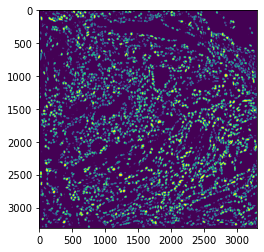

In [37]:
haha = np.load(os.path.join(save_npy_path,test[0]))
hehe = np.load(os.path.join(save_npy_path,test[1]))
list_image = glob.glob(image_path+'*.png')
tuxiang0 = cv2.imread(list_image[0])
tuxiang1 = cv2.imread(list_image[1])
print(tuxiang0.shape)
print(tuxiang1.shape)
print(haha.shape)
print(np.unique(haha))
print(np.unique(hehe))
plt.imshow(haha)
plt.show()